## Sample Rate and Extraction Interval Impact Assessment

---

### Objective:

- To assess the impact of different sample rates on the performance of the model and how this is affected by the extraction interval.
- To determine the optimal sample rate and interval for the model features extraction.

### Methodology:

- A model (RF, SVM, LR) is trained with different features (Chroma, MFCC_30, MFCC_120, CQT_30, CQT_70), sample rates (mixed, 4000) and extraction intervals (0.5s, 1s, 2s). The features are used 'as extracted' without any additional processing.
- The model is trained with 80% of the data and tested with the remaining 20%.

#### Findings:

- No clear advantage of using a mix of frequencies over a fixed sample rate. Actually, a fixed sample rate of 4000Hz lead to a lower risk of bias introduction, to a better efficiency and allows to the usage of a larger variety of features.


In [145]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score, matthews_corrcoef

from sklearn.svm import SVC
import tqdm.notebook as tqdm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.style.use("seaborn-v0_8-paper")
import seaborn as sns

sns.set_theme(context="paper", font_scale=1)

### Set the Paths


In [146]:
# set the paths
BASE_DIR = "../../dataset/"
LABELS = BASE_DIR + "labels.csv"

# features
FEATURES_BASE = "../../features/"
FEATURES = FEATURES_BASE + "raw/"

# Models
MODELS = '../../models/'
MODELS_RESULTS = MODELS + 'results/'

# report
PAPER = '../../paper/'
IMAGES_PATH = PAPER + 'images/'

# HYERPARAMETERS
SEED = 42
INTERVAL = 3 # 0.5, 1, 2, 3
METRIC = 'mcc' # 'acc', 'microf1', 'macrof1', 'mcc'

### Load the Data and Train the Model


In [147]:
SEED = 42
full_data_dict_keys = ['artifacts', 'extrahls', 'murmurs', 'normals', 'extrastoles']
interval = INTERVAL
sample_rates = ['mix', 4000]
num_feats = [30, 120, 12, 30, 70]
type_ = ["mfcc", "mfcc", "chroma", "cqt", "cqt"]

# dataframe where to store the results
results_rf = pd.DataFrame(
    columns=["mfcc_30", "mfcc_120", "chroma_12", "cqt_30", "cqt_70"],
    index=["mix", "4000"],
)
results_svm = pd.DataFrame(
    columns=["mfcc_30", "mfcc_120", "chroma_12", "cqt_30", "cqt_70"],
    index=["mix", "4000"],
)
results_lr = pd.DataFrame(
    columns=["mfcc_30", "mfcc_120", "chroma_12", "cqt_30", "cqt_70"],
    index=["mix", "4000"],
)

for sample_rate in sample_rates:
    for i, num_feat in enumerate(num_feats):
          print(f'Processing {sample_rate}hz_{num_feat}{type_[i]}\n')

          # define the features name and load the data
          FEATURES_NAME = f'full_data_{interval}s_{sample_rate}hz_{num_feat}{type_[i]}.npy'
          full_data = np.load(FEATURES + FEATURES_NAME, allow_pickle=True).item()
          
          # extract the data from the dict
          data_list = []
          for key in full_data_dict_keys:
               X = full_data[key]['X']
               y = full_data[key]['y']
               data = np.concatenate((X, y.reshape(-1, 1)), axis=1)
               data_list.append(data)
          full_data_array = np.concatenate(data_list, axis=0)
          
          # split the data into train and test
          X = full_data_array[:, :-1]
          y = full_data_array[:, -1]
          X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)
          
          print('Training random forest\n')
          # train the RF model
          clf = RandomForestClassifier(random_state=SEED)
          clf.fit(X_train, y_train)
          
          # evaluate the model
          
          if METRIC =='macrof1':
                y_pred = clf.predict(X_test)
                score = f1_score(y_test, y_pred, average='macro')
          elif METRIC == 'microf1':
                y_pred = clf.predict(X_test)
                score = f1_score(y_test, y_pred, average='micro')
          elif METRIC == 'acc':
                score = clf.score(X_test, y_test)
          elif METRIC == 'mcc':
                y_pred = clf.predict(X_test)
                score = matthews_corrcoef(y_test, y_pred)
          
          # store the results
          results_rf.iloc[sample_rates.index(sample_rate), i] = score
          
          print('Training SVM\n')
          # train the SVM
          clf = SVC(random_state=SEED)
          clf.fit(X_train, y_train)
          
          # evaluate the model
          if METRIC =='macrof1':
                y_pred = clf.predict(X_test)
                score = f1_score(y_test, y_pred, average='macro')
          elif METRIC == 'microf1':
                y_pred = clf.predict(X_test)
                score = f1_score(y_test, y_pred, average='micro')
          elif METRIC == 'acc':
                score = clf.score(X_test, y_test)
          elif METRIC == 'mcc':
                y_pred = clf.predict(X_test)
                score = matthews_corrcoef(y_test, y_pred)
          
          
          # store the results
          results_svm.iloc[sample_rates.index(sample_rate), i] = score
          
          print('Training logistic regression\n')
          # train the LR
          clf = LogisticRegression(random_state=SEED, max_iter=300)
          clf.fit(X_train, y_train)
          
          # evaluate the model
          if METRIC =='macrof1':
                y_pred = clf.predict(X_test)
                score = f1_score(y_test, y_pred, average='macro')
          elif METRIC == 'microf1':
                y_pred = clf.predict(X_test)
                score = f1_score(y_test, y_pred, average='micro')
          elif METRIC == 'acc':
                score = clf.score(X_test, y_test)
          elif METRIC == 'mcc':
                y_pred = clf.predict(X_test)
                score = matthews_corrcoef(y_test, y_pred)
          
          # store the results
          results_lr.iloc[sample_rates.index(sample_rate), i] = score
                
          
# save the results
results_rf.to_csv(MODELS_RESULTS + f'results_rf_{interval}s_{METRIC}.csv')
results_svm.to_csv(MODELS_RESULTS + f'results_svm_{interval}s_{METRIC}.csv')
results_lr.to_csv(MODELS_RESULTS + f'results_lr_{interval}s_{METRIC}.csv')

Processing mixhz_30mfcc

Training random forest

Training SVM

Training logistic regression

Processing mixhz_120mfcc

Training random forest



/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training SVM

Training logistic regression



/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Processing mixhz_12chroma

Training random forest

Training SVM

Training logistic regression

Processing mixhz_30cqt

Training random forest

Training SVM

Training logistic regression

Processing mixhz_70cqt

Training random forest

Training SVM

Training logistic regression

Processing 4000hz_30mfcc

Training random forest

Training SVM

Training logistic regression

Processing 4000hz_120mfcc

Training random forest



/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training SVM

Training logistic regression



/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Processing 4000hz_12chroma

Training random forest

Training SVM

Training logistic regression

Processing 4000hz_30cqt

Training random forest

Training SVM

Training logistic regression

Processing 4000hz_70cqt

Training random forest

Training SVM

Training logistic regression



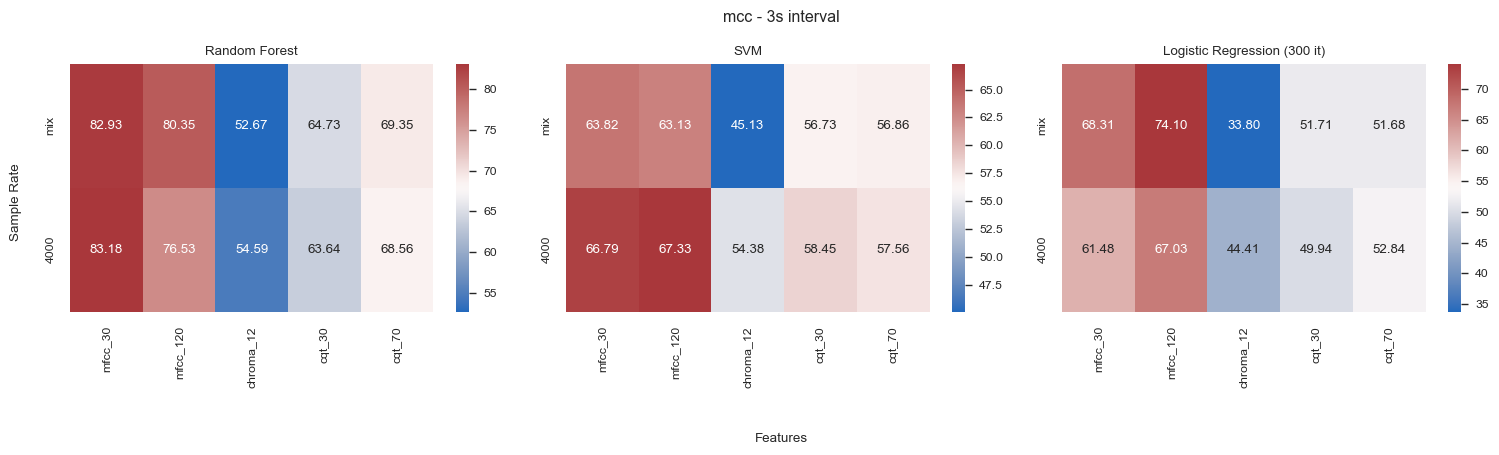

In [148]:
fig, axs = plt.subplots(1, 3, figsize=(15, 4))

sns.heatmap(
    results_rf.astype(float) * 100, annot=True, cmap="vlag", fmt=".2f", ax=axs[0]
)
axs[0].set_title("Random Forest")

sns.heatmap(
    results_svm.astype(float) * 100, annot=True, cmap="vlag", fmt=".2f", ax=axs[1]
)
axs[1].set_title("SVM")

sns.heatmap(
    results_lr.astype(float) * 100, annot=True, cmap="vlag", fmt=".2f", ax=axs[2]
)
axs[2].set_title("Logistic Regression (300 it)")

fig.suptitle(f'{METRIC} - {interval}s interval')
# xlabel and ylabel for entire fig
fig.text(0.5, -0.1, 'Features', ha='center')
fig.text(-0.014, 0.5, 'Sample Rate', va='center', rotation='vertical')

plt.tight_layout()
plt.show()


# save the figure
fig.savefig(IMAGES_PATH + f'{METRIC}_{interval}s.png', dpi=300)

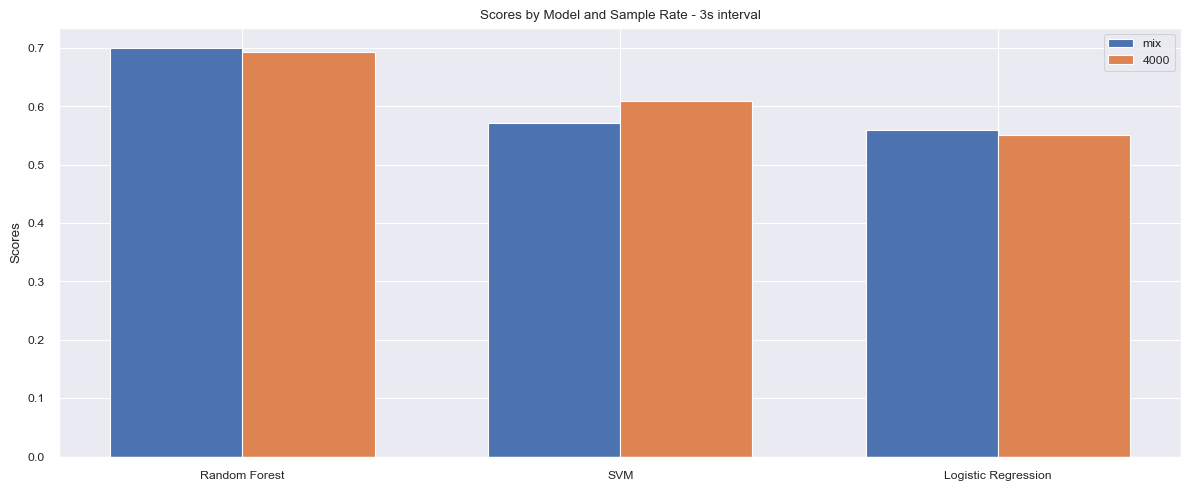

In [149]:
sr_mean_rf = results_rf.mean(axis=1)
sr_mean_svm = results_svm.mean(axis=1)
sr_mean_lr = results_lr.mean(axis=1)
df = pd.DataFrame(
    [sr_mean_rf, sr_mean_svm, sr_mean_lr],
    index=["Random Forest", "SVM", "Logistic Regression"],
)
index = df.index

# Define the positions for each set of bars
bar_width = 0.35
x = np.arange(len(index))  # the label locations
x_mix = x - bar_width / 2
x_4000 = x + bar_width / 2

# Plot the data
fig, ax = plt.subplots(figsize=(12, 5))
mix = ax.bar(x_mix, df["mix"], bar_width, label="mix")
_4000 = ax.bar(x_4000, df["4000"], bar_width, label="4000")

# Add labels and legend
ax.set_ylabel('Scores')
ax.set_title(f'Scores by Model and Sample Rate - {interval}s interval')
ax.set_xticks(x)
ax.set_xticklabels(index)
ax.legend()
plt.tight_layout()
plt.show()

# save the figure
fig.savefig(IMAGES_PATH + f'mean_{METRIC}_models_{interval}s.png', dpi=300)


### Extraction Interval Impact Assessment

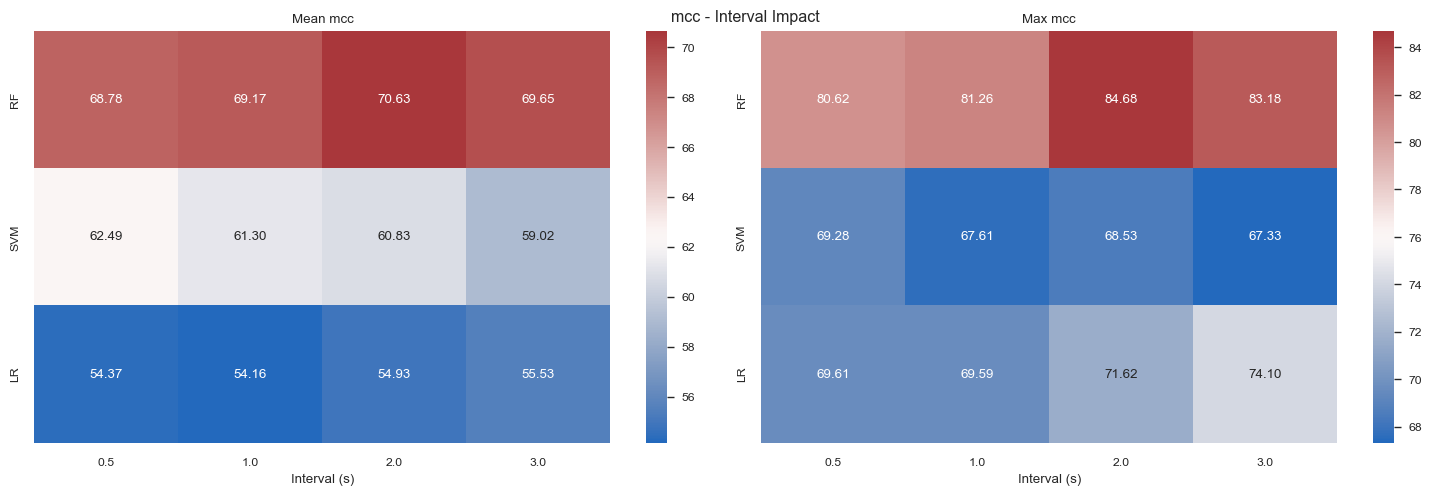

In [150]:
# define dataframe having models as columns and intervals as rows
df_mean = pd.DataFrame(columns=[0.5, 1, 2, 3], index=["RF", "SVM", "LR"])
df_max = pd.DataFrame(columns=[0.5, 1, 2, 3], index=["RF", "SVM", "LR"])

# load the results
for interval in [0.5, 1, 2, 3]:
	results_rf = pd.read_csv(MODELS_RESULTS + f'results_rf_{interval}s_{METRIC}.csv', index_col=0)
	results_svm = pd.read_csv(MODELS_RESULTS + f'results_svm_{interval}s_{METRIC}.csv', index_col=0)
	results_lr = pd.read_csv(MODELS_RESULTS + f'results_lr_{interval}s_{METRIC}.csv', index_col=0)
 
	# extract mean and max values
	mean_rf = results_rf.mean().mean()
	max_rf = results_rf.max().max()
	mean_svm = results_svm.mean().mean()
	max_svm = results_svm.max().max()
	mean_lr = results_lr.mean().mean()
	max_lr = results_lr.max().max()
 
	# update the dataframes
	df_mean.iloc[0, df_mean.columns.get_loc(interval)] = mean_rf
	df_mean.iloc[1, df_mean.columns.get_loc(interval)] = mean_svm
	df_mean.iloc[2, df_mean.columns.get_loc(interval)] = mean_lr
 
	df_max.iloc[0, df_max.columns.get_loc(interval)] = max_rf
	df_max.iloc[1, df_max.columns.get_loc(interval)] = max_svm
	df_max.iloc[2, df_max.columns.get_loc(interval)] = max_lr

# plot the data
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

sns.heatmap(df_mean.astype(float) * 100, annot=True, cmap="vlag", fmt=".2f", ax=axs[0])
axs[0].set_title(F"Mean {METRIC}")
axs[0].set_xlabel("Interval (s)")

sns.heatmap(df_max.astype(float) * 100, annot=True, cmap="vlag", fmt=".2f", ax=axs[1])
axs[1].set_title(F"Max {METRIC}")
axs[1].set_xlabel("Interval (s)")

plt.tight_layout()

fig.suptitle(F"{METRIC} - Interval Impact")

# save
fig.savefig(IMAGES_PATH + f'{METRIC}_interval_impact.png', dpi=300)


### Investigate number of samples for each extraction interval

Text(0, 0.5, 'Number of Samples')

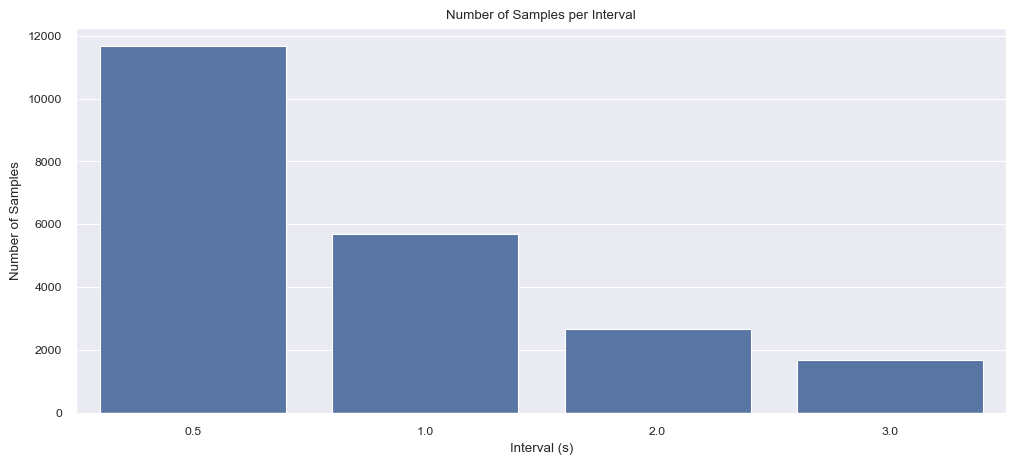

In [151]:
# investigate the number of samples for each extraction interval
num_samples = []
full_data_dict_keys = ['artifacts', 'extrahls', 'murmurs', 'normals', 'extrastoles']

for interval in [0.5, 1, 2, 3]:
    FEATURES_NAME = f'full_data_{interval}s_mixhz_30mfcc.npy'
    full_data = np.load(FEATURES + FEATURES_NAME, allow_pickle=True).item()

    data_list = []
    for key in full_data_dict_keys:
          X = full_data[key]['X']
          y = full_data[key]['y']
          data = np.concatenate((X, y.reshape(-1, 1)), axis=1)
          data_list.append(data)
    full_data_array = np.concatenate(data_list, axis=0)
    num_samples.append(full_data_array.shape[0])
    
# plot the data
fig, ax = plt.subplots(figsize=(12, 5))
sns.barplot(x=[0.5, 1, 2, 3], y=num_samples, ax=ax)
ax.set_title("Number of Samples per Interval")
ax.set_xlabel("Interval (s)")
ax.set_ylabel("Number of Samples")

### Investigate the class distribution for each extraction interval

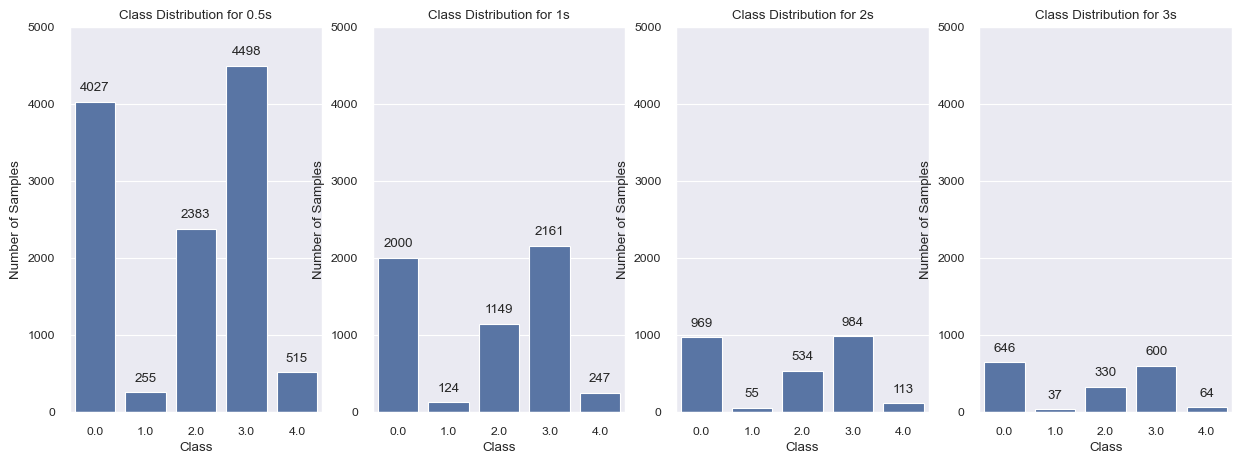

In [153]:
# investigate the class distribution for each extraction interval
class_distribution = []
import numpy as np 
for interval in [0.5, 1, 2, 3]:
    FEATURES_NAME = f'full_data_{interval}s_mixhz_30mfcc.npy'
    full_data = np.load(FEATURES + FEATURES_NAME, allow_pickle=True).item()

    data_list = []
    for key in full_data_dict_keys:
        X = full_data[key]['X']
        y = full_data[key]['y']
        data = np.concatenate((X, y.reshape(-1, 1)), axis=1)
        data_list.append(data)
    full_data_array = np.concatenate(data_list, axis=0)
    class_distribution.append(np.unique(full_data_array[:, -1], return_counts=True)[1])
    
# plot the data
fig, ax = plt.subplots(1,4 , figsize=(15, 5))
for i, interval in enumerate([0.5, 1, 2, 3]):
    sns.barplot(x=np.unique(full_data_array[:, -1]), y=class_distribution[i], ax=ax[i])
    # min and max set
    ax[i].set_ylim([0, 5000])
    ax[i].set_title(f"Class Distribution for {interval}s")
    ax[i].set_xlabel("Class")
    ax[i].set_ylabel("Number of Samples")
    # add value as int on top of the bars
    for p in ax[i].patches:
        ax[i].annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')